In [81]:
import torch
import pandas as pd
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
%matplotlib inline

In [84]:
class AbaloneDeep(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            columns = ['sex', 'length', 'diameter', 'height', 'whole_weight',
                       'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
            df = pd.read_csv('../data/abalone.csv', header=None,
                             names=columns, index_col=False)
            df_train, df_val = train_test_split(df, test_size=0.30, random_state=42)
            df_train = df_train.reset_index()
            df_val = df_val.reset_index()
            self.raw_train = df_train
            self.raw_val = df_val

In [85]:
columns = ['sex', 'length', 'diameter', 'height', 'whole_weight',
           'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
df = pd.read_csv('../data/abalone.csv', header=None,
                 names=columns, index_col=False)
df_train, df_val = train_test_split(df, test_size=0.30, random_state=42)
df_train = df_train.reset_index()
df_val = df_val.reset_index()

In [86]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(df_train, batch_size=batch_size)
test_dataloader = DataLoader(df_val, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

KeyError: 0

In [87]:
class AbaloneDeep(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            columns = ['sex', 'length', 'diameter', 'height', 'whole_weight',
                       'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
            df = pd.read_csv('../data/abalone.csv', header=None,
                             names=columns, index_col=False)
            df_train, df_val = train_test_split(df, test_size=0.30, random_state=42)
            df_train = df_train.reset_index()
            df_val = df_val.reset_index()
            self.raw_train = df_train
            self.raw_val = df_val

In [88]:
data = AbaloneDeep(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(2923, 10)
(1254, 10)


In [89]:
data.raw_train.head()

,index,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,2830,F,0.525,0.430,0.135,0.8435,0.4325,0.1800,0.1815,9
1,925,I,0.430,0.325,0.100,0.3645,0.1575,0.0825,0.1050,7
2,3845,M,0.455,0.350,0.105,0.4160,0.1625,0.0970,0.1450,11
3,547,M,0.205,0.155,0.045,0.0425,0.0170,0.0055,0.0155,7
4,2259,F,0.590,0.465,0.160,1.1005,0.5060,0.2525,0.2950,13


In [90]:
@d2l.add_to_class(AbaloneDeep)
def preprocess(self):
    # Remove the ID and label columns
    label = 'rings'
    features = pd.concat(
        (self.raw_train.drop(columns=label),
         self.raw_val.drop(columns=label)))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes != 'object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding.
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [91]:
data.preprocess()
data.train.shape

(2923, 13)

In [92]:
@d2l.add_to_class(AbaloneDeep)
def get_dataloader(self, train):
    label = 'rings'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
    # Logarithm of rings
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

In [93]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(AbaloneDeep(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [94]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

In [95]:
data.train

,index,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_F,sex_I,sex_M,sex_nan,rings
0,0.615287,0.008393,0.222882,-0.107978,0.030094,0.329481,-0.005415,-0.411852,1,0,0,0,9
1,-0.964393,-0.782662,-0.835161,-0.944757,-0.946681,-0.909465,-0.894898,-0.961410,0,1,0,0,7
2,1.456954,-0.574489,-0.583246,-0.825217,-0.841663,-0.886939,-0.762616,-0.674059,0,0,1,0,11
3,-1.277841,-2.656211,-2.548182,-2.259695,-1.603303,-1.542453,-1.597362,-1.604358,0,0,1,0,7
4,0.141798,0.549640,0.575563,0.489721,0.554168,0.660617,0.655995,0.403506,1,0,0,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918,1.124434,-0.283048,-0.079416,-0.586137,-0.529666,-0.465697,-0.438753,-0.674059,1,0,0,0,9
2919,-1.345008,1.215791,1.432073,1.206960,1.145535,0.825059,1.121263,1.157802,1,0,0,0,12
2920,0.832545,-0.116511,-0.129799,-0.347058,-0.506215,-0.519760,-0.429630,-0.365157,0,0,1,0,11
2921,1.396421,0.424737,0.575563,-0.466597,0.458326,0.705670,0.345816,-0.027520,0,0,1,0,9


/home/studio-lab-user/.conda/envs/py39/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/studio-lab-user/.conda/envs/py39/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/studio-lab-user/.conda/envs/py39/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/studio-lab-user/.conda/envs/py39/lib/python3.9/site-packages/torch/nn/modules/lazy

average validation log mse = 0.04869654841721057


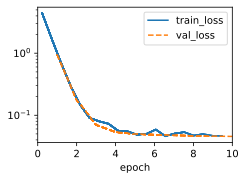

In [96]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)